# Sentiment Analysis on Amazon Reviews

In [36]:
!pip install -q wordcloud scikit-learn matplotlib pandas nltk seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91705\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
path = 'amazonreviews.tsv'
df = pd.read_csv(path, sep='\t')
df.shape
df.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [39]:
print('Before drop:', df.shape)
df = df.drop_duplicates()
df = df.dropna(subset=['review','label'])
print('After drop:', df.shape)
df['label'] = df['label'].str.strip()
df['review'] = df['review'].astype(str)
df['label'].value_counts()

Before drop: (10000, 2)
After drop: (10000, 2)


label
neg    5097
pos    4903
Name: count, dtype: int64

In [40]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t)>1]
    return ' '.join(tokens)

# apply
sample = df['review'].iloc[:3].tolist()
cleaned = [clean_text(t) for t in sample]
cleaned

['stuning even non gamer sound track beautiful paints senery mind well would recomend even people hate vid game music played game chrono cross games ever played best music backs away crude keyboarding takes fresher step grate guitars soulful orchestras would impress anyone cares listen',
 'best soundtrack ever anything reading lot reviews saying best game soundtrack figured write review disagree bit opinino yasunori mitsuda ultimate masterpiece music timeless listening years beauty simply refuses fade price tag pretty staggering must say going buy cd much money one feel would worth every penny',
 'amazing soundtrack favorite music time hands intense sadness prisoners fate means played game hope distant promise girl stole star important inspiration personally throughout teen years higher energy tracks like chrono cross time scar time dreamwatch chronomantique indefinably remeniscent chrono trigger absolutely superb well soundtrack amazing music probably best composer work heard xenogear

In [41]:
df['clean_review'] = df['review'].apply(clean_text)
df[['review','clean_review']].head()

,review,clean_review
0,Stuning even for the non-gamer: This sound tra...,stuning even non gamer sound track beautiful p...
1,The best soundtrack ever to anything.: I'm rea...,best soundtrack ever anything reading lot revi...
2,Amazing!: This soundtrack is my favorite music...,amazing soundtrack favorite music time hands i...
3,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack truly like soundtrack enj...
4,"Remember, Pull Your Jaw Off The Floor After He...",remember pull jaw floor hearing played game kn...


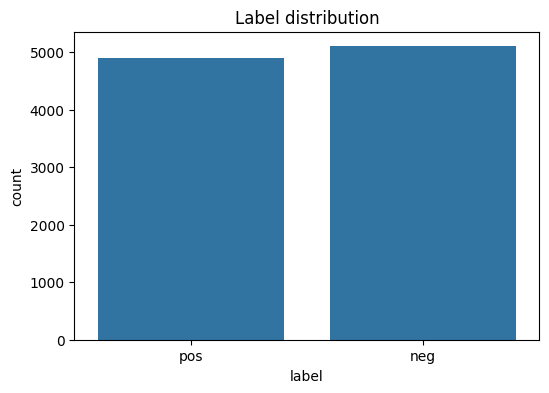

label
neg    5097
pos    4903
Name: count, dtype: int64


In [42]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label')
plt.title('Label distribution')
plt.show()

print(df['label'].value_counts())

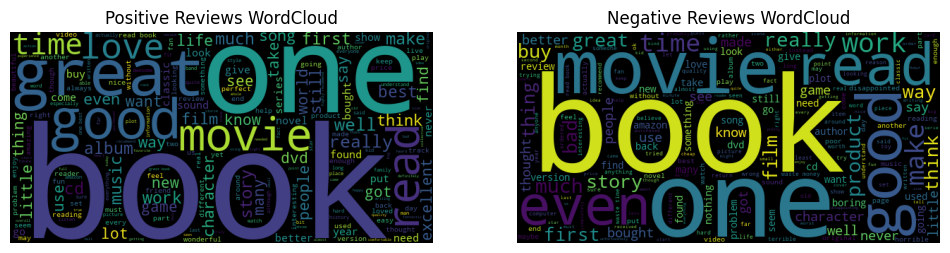

In [43]:
pos_text = ' '.join(df.loc[df['label']=='pos','clean_review'].astype(str).tolist())
neg_text = ' '.join(df.loc[df['label']=='neg','clean_review'].astype(str).tolist())

wc_pos = WordCloud(width=600, height=300).generate(pos_text)
wc_neg = WordCloud(width=600, height=300).generate(neg_text)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(wc_pos)
plt.axis('off')
plt.title('Positive Reviews WordCloud')

plt.subplot(1,2,2)
plt.imshow(wc_neg)
plt.axis('off')
plt.title('Negative Reviews WordCloud')

plt.show()

In [44]:
from collections import Counter

def top_n_words(text, n=20):
    words = text.split()
    return Counter(words).most_common(n)

print('Top positive words:', top_n_words(pos_text, 15))
print('\nTop negative words:', top_n_words(neg_text, 15))

Top positive words: [('book', 3390), ('great', 2135), ('one', 1916), ('good', 1667), ('read', 1605), ('like', 1290), ('movie', 1121), ('would', 956), ('well', 944), ('time', 924), ('love', 911), ('really', 832), ('best', 813), ('get', 805), ('story', 730)]

Top negative words: [('book', 3277), ('one', 2100), ('like', 1569), ('movie', 1519), ('would', 1465), ('read', 1222), ('good', 1160), ('get', 1151), ('time', 1072), ('even', 910), ('buy', 835), ('really', 783), ('much', 782), ('money', 767), ('bad', 764)]


In [45]:
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(df['clean_review'])
y = df['label'].map({'pos':1, 'neg':0}).values
print('X shape', X.shape)

X shape (10000, 10000)


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)

(8000, 10000) (2000, 10000)


In [47]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
print('LR accuracy', accuracy_score(y_test, pred_lr))
print('LR F1', f1_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

LR accuracy 0.8585
LR F1 0.8543489449305198
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1019
           1       0.86      0.85      0.85       981

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



In [48]:
svm = LinearSVC(max_iter=10000)
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)
print('SVM accuracy', accuracy_score(y_test, pred_svm))
print('SVM F1', f1_score(y_test, pred_svm))
print(classification_report(y_test, pred_svm))

SVM accuracy 0.8435
SVM F1 0.8402246043899949
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1019
           1       0.84      0.84      0.84       981

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



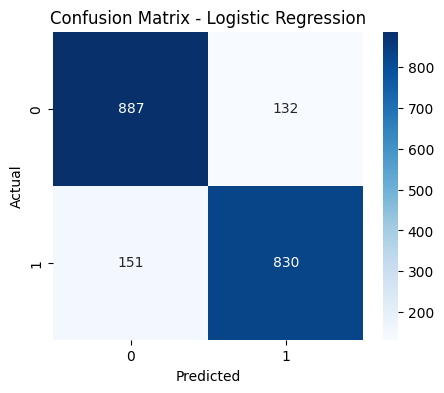

In [49]:
cm = confusion_matrix(y_test, pred_lr)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [50]:
scores = cross_val_score(LogisticRegression(max_iter=1000), X, y, cv=5, scoring='f1')
print('5-fold F1 scores:', scores)
print('Mean F1:', scores.mean())

5-fold F1 scores: [0.86236668 0.82666667 0.82008368 0.84316692 0.85032978]
Mean F1: 0.8405227465834569


In [51]:
new_texts = ['This product is amazing, I loved it', 'Terrible quality. Broke after one use', 'Not what I expected but okay for the price']
new_clean = [clean_text(t) for t in new_texts]
new_vec = tfidf.transform(new_clean)
preds = lr.predict(new_vec)
for t,p in zip(new_texts, preds):
    print(t, '->', 'pos' if p==1 else 'neg')

This product is amazing, I loved it -> pos
Terrible quality. Broke after one use -> neg
Not what I expected but okay for the price -> neg


In [52]:
import pickle, os
os.makedirs('models', exist_ok=True)

with open('models/tfidf_vectorizer.pkl','wb') as f:
    pickle.dump(tfidf, f)

with open('models/logreg_model.pkl','wb') as f:
    pickle.dump(lr, f)

print('Saved vectorizer and model to models/')


Saved vectorizer and model to models/
